In [1]:
# Import different tools and library

!pip install python -m spacy download en_core_web_sm
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import spacy.cli
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("average_perceptron_tagger")
spacy.cli.download("en_core_web_sm")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -m
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SHEKO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHEKO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHEKO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHEKO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading aver

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import Tweets data set

cr_tweets = pd.read_csv("C:/Users/SHEKO/Desktop/cr_tweets.csv")
print(cr_tweets.head())
print(cr_tweets.describe())

interaction_totals = {cr_tweets["likeCount"].sum(), cr_tweets["replyCount"].sum(), cr_tweets["retweetCount"].sum(), 
                      cr_tweets["quoteCount"].sum(), cr_tweets["bookmarkCount"].sum()}
interaction_means = {cr_tweets["likeCount"].mean(), cr_tweets["replyCount"].mean(), cr_tweets["retweetCount"].mean(), 
                      cr_tweets["quoteCount"].mean(), cr_tweets["bookmarkCount"].mean()}
print(interaction_totals)
print(interaction_means)

                    id                       createdAt  \
0  1750522838283649232  Thu Jan 25 14:15:42 +0000 2024   
1  1740707339588825311  Fri Dec 29 12:12:25 +0000 2023   
2  1736824246070890705  Mon Dec 18 19:02:23 +0000 2023   
3  1736404837649023475  Sun Dec 17 15:15:48 +0000 2023   
4  1732473555923644630  Wed Dec 06 18:54:18 +0000 2023   

                                                text  retweetCount  \
0  Had an amazing time with @Binance, creating th...          5657   
1  With the best fireworks show in the world - me...          9365   
2  Great memory with my SIXPAD family from the Co...         11088   
3  Grateful to be honored as the most searched at...         21526   
4  Funchal is the capital and tourist centre of M...         14517   

   replyCount  likeCount  quoteCount  bookmarkCount  
0        3676      50466         141            186  
1        8766      99551         310            364  
2        6263     130247         374            753  
3        7213 

In [3]:
# Data preprocessing

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Clean the Tweets

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+|", "", text, flags = re.MULTILINE)                # Remove URLs
    text = re.sub(r"\@\S+|\#\S+", "", text)                             # Remove user, tags, and hashtags from tweet
    text = re.sub(r"[^A-Za-z\s]+", "", text)                            # Remove special characters and digits
    text = text.lower()                                                 # Convert to lowercase
    tokens = word_tokenize(text)                                        # Tokenization
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return "".join(processed_tokens)
cr_tweets["processed_text"] = cr_tweets["text"].apply(preprocess_text)
print("\n--- Processed Tweets ---")
print(cr_tweets[["text", "processed_text"]].head())


--- Processed Tweets ---
                                                text  \
0  Had an amazing time with @Binance, creating th...   
1  With the best fireworks show in the world - me...   
2  Great memory with my SIXPAD family from the Co...   
3  Grateful to be honored as the most searched at...   
4  Funchal is the capital and tourist centre of M...   

                                      processed_text  
0  amazingtimecreatingnextlevelfanexperiencethank...  
1  bestfireworkshowworldmentionedguinnessbookreco...  
2  greatmemorysixpadfamilycorebelteventjapanlastjuly  
3     gratefulhonoredsearchedathletehistorycheckfilm  
4  funchalcapitaltouristcentremadeiravibrantcityf...  


In [4]:
# Sentiment Analysis

#Method 1: TextBlob

def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return " Neutral"
    else:
        return "Negative"
cr_tweets["sentiment_textblob"] = cr_tweets["text"].apply(get_textblob_sentiment)
print(cr_tweets["sentiment_textblob"].describe())

# Method 2: VADER (Valence Aware Dictionary and sEntiment Reasoner)

analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    if vs["compound"] >= 0.05:
        return "Positive"
    elif vs["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"
cr_tweets["sentiment_vader"] = cr_tweets["text"].apply(get_vader_sentiment)
cr_tweets["sentiment_label"] = cr_tweets["sentiment_vader"].apply(get_vader_sentiment)
print(cr_tweets["sentiment_vader"].describe())
print(cr_tweets["sentiment_label"])

sentiment_counts_vader = cr_tweets["sentiment_vader"].value_counts()            # Sentiment counts from VADER
sentiment_counts_textblob = cr_tweets["sentiment_textblob"].value_counts()      # Sentiment counts from TextBlob
print(sentiment_counts_vader)
print(sentiment_counts_textblob)

print("\n--- Sentiment Analysis Results ---")
print(cr_tweets[["text", "sentiment_textblob", "sentiment_vader"]].head())

count          794
unique           3
top        Neutral
freq           415
Name: sentiment_textblob, dtype: object
count          794
unique           3
top       Positive
freq           489
Name: sentiment_vader, dtype: object
0      Positive
1      Positive
2      Positive
3      Positive
4      Positive
         ...   
789     Neutral
790    Positive
791     Neutral
792    Positive
793    Positive
Name: sentiment_label, Length: 794, dtype: object
sentiment_vader
Positive    489
Neutral     262
Negative     43
Name: count, dtype: int64
sentiment_textblob
 Neutral    415
Positive    340
Negative     39
Name: count, dtype: int64

--- Sentiment Analysis Results ---
                                                text sentiment_textblob  \
0  Had an amazing time with @Binance, creating th...           Positive   
1  With the best fireworks show in the world - me...           Positive   
2  Great memory with my SIXPAD family from the Co...           Positive   
3  Grateful to be honored 

In [5]:
# Keyword extraction

def get_most_common_keywords(texts_series, top_n = 10):
    vectorizer = CountVectorizer(max_features = 1000)
    X = vectorizer.fit_transform(texts_series)
    sum_words = X.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:top_n]
common_keywords = get_most_common_keywords(cr_tweets["processed_text"])
print("\n--- Most Common Keywords ---")

# Named Entity Recognition (NER)

try:
    nlp_spacy = spacy.load('en_core_web_sm')
    print("spaCy model is succesfully download")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Please run: python -m spacy download en_core_web_sm")
    nlp_spacy = None
def get_named_entities(text):
    if not nlp_spacy:
        return []
    doc = nlp_spacy(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities
if nlp_spacy:
    cr_tweets["named_entities"] = cr_tweets["text"].apply(get_named_entities)
    print("\n--- Named Entity Recognition (NER) ---")
    for index, row in cr_tweets.head().iterrows():
        print(f"Tweet: {row["text"]}")
        print(f"Entities: {row["named_entities"]}\n")
else:
    cr_tweets["named_entities"] = [[] for _ in range(len(cr_tweets))]
print("\n--- Final DataFrame with Analysis ---")
print(cr_tweets[["text", "processed_text", "sentiment_textblob", "sentiment_vader", "named_entities"]].to_string())


--- Most Common Keywords ---
spaCy model is succesfully download

--- Named Entity Recognition (NER) ---
Tweet: Had an amazing time with @Binance, creating the next level of fan-experience.

Thanks to my ForeverCR7 NFT collection, I got to meet and train with the holders of my rarest NFTs.

Watch the full video: https://t.co/HSQFUHvrIl https://t.co/x8jzkJiPK1
Entities: [('@Binance', 'PERSON'), ('https://t.co/HSQFUHvrIl https://t.co/x8jzkJiPK1', 'PERSON')]

Tweet: With the best fireworks show in the world - mentioned in the Guinness Book of Records – Madeira is known for entering the new year with a bang. Are you ready to have the time of your life? https://t.co/bMgGKzmZLM
Entities: [('the Guinness Book of Records – Madeira', 'ORG'), ('the new year', 'DATE')]

Tweet: Great memory with my SIXPAD family from the Core Belt event in Japan last July. @SIXPAD_official #SIXPAD #JAPAN #corebelt #trainning #EMS #CR7 https://t.co/cmwmJTekNh
Entities: [('Japan', 'GPE'), ('last July', 'DATE'), ('#

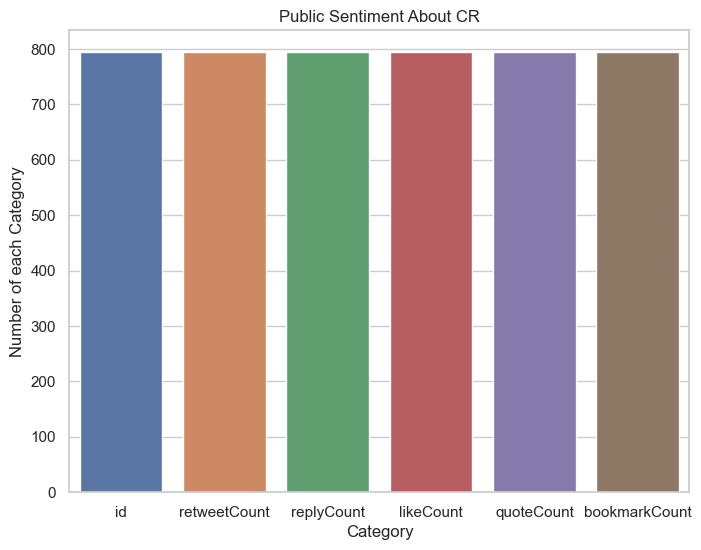

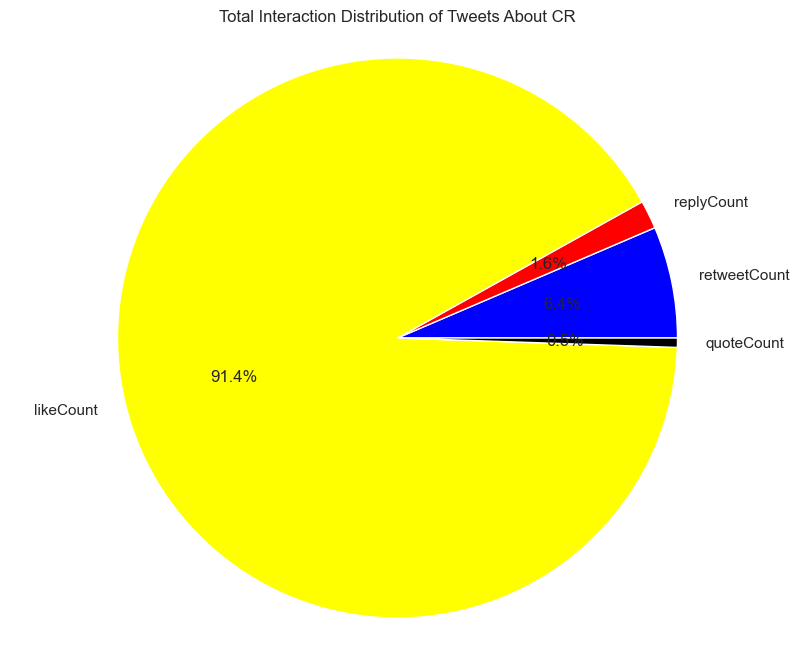

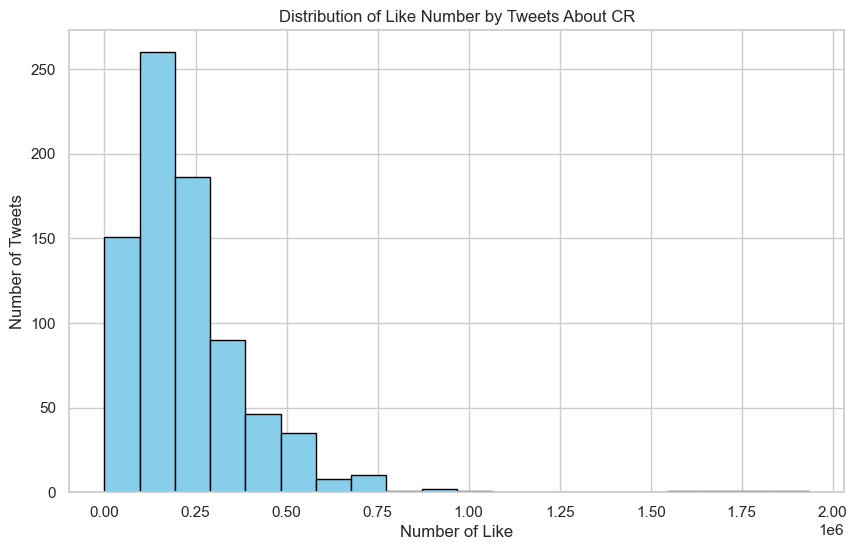

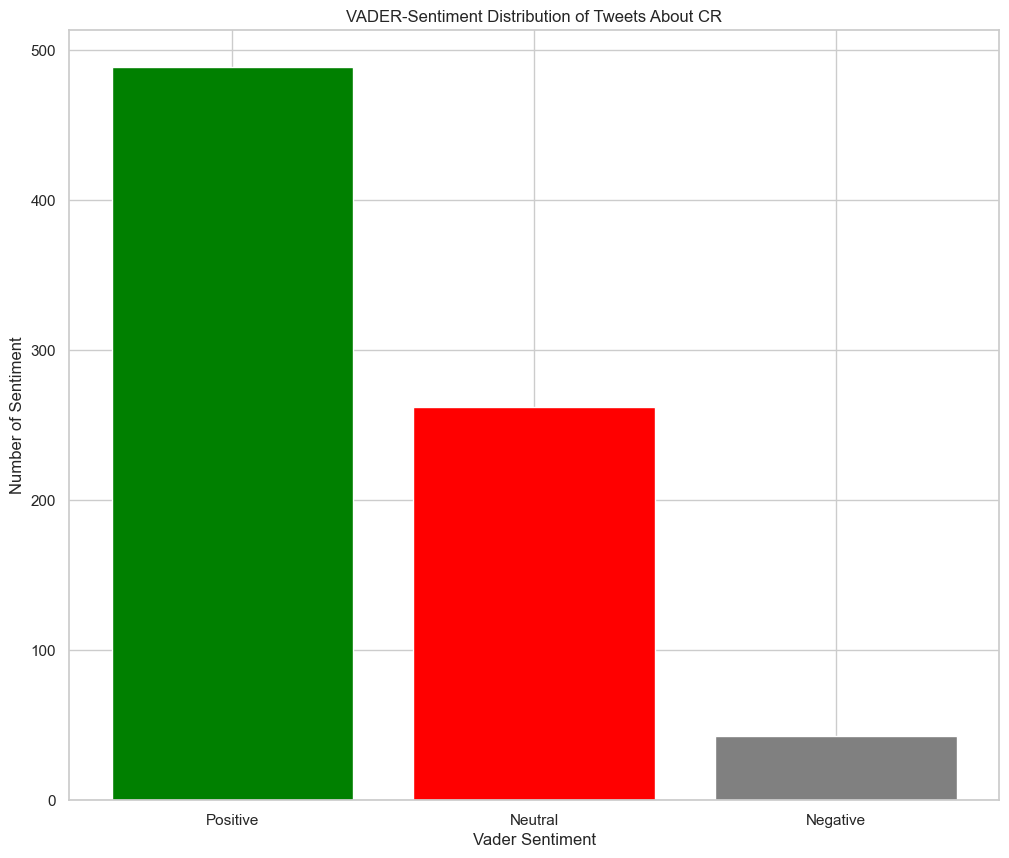

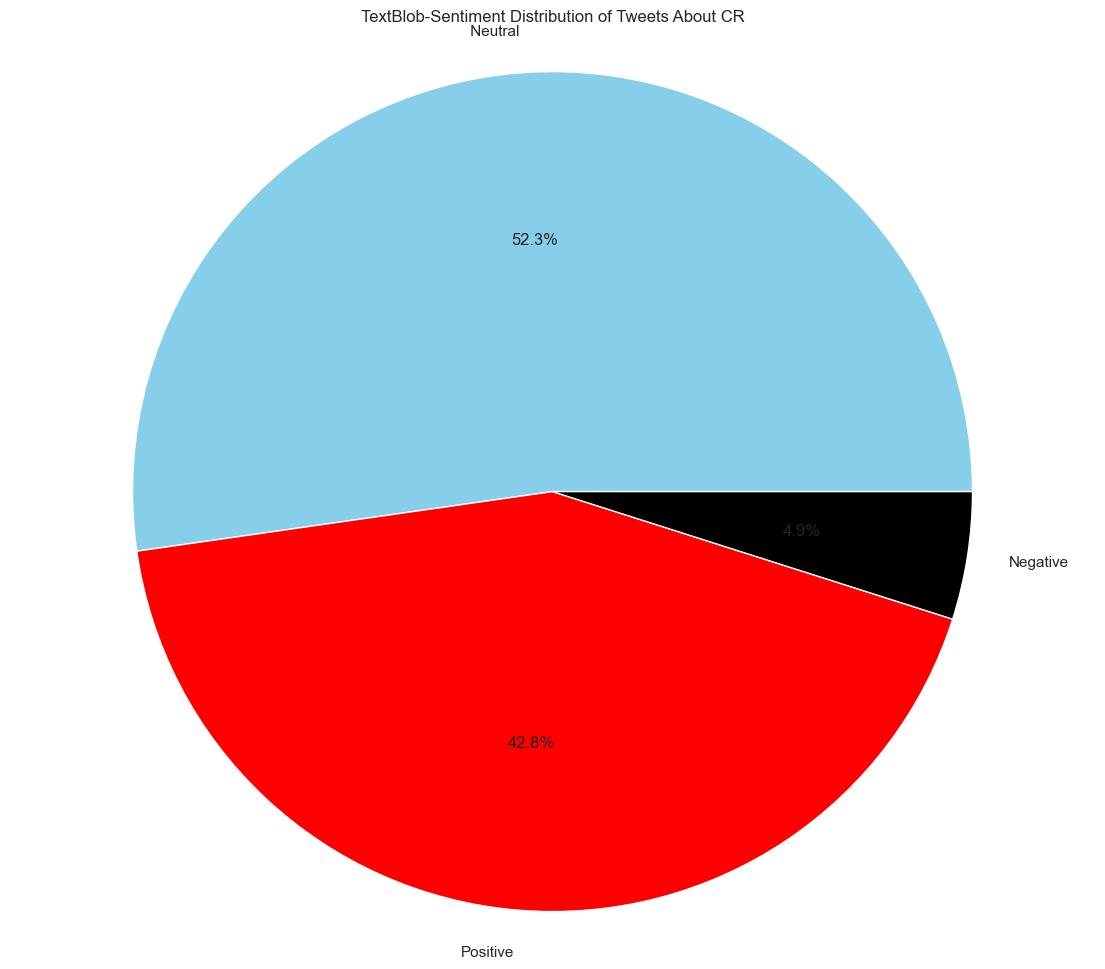

In [6]:
# Visualize Sentiment

# Create a chart to show number of tweets and interaction

sns.set(style = "whitegrid")
plt.figure(figsize = (8, 6))
sns.countplot(data = cr_tweets, legend = False)
plt.title("Public Sentiment About CR")
plt.xlabel("Category")
plt.ylabel("Number of each Category")
plt.show()

# Create a Pie chart to show total number of interactin with each tweet

interaction_columns = ["retweetCount", "replyCount", "likeCount", "quoteCount"]
interaction_totals = cr_tweets[interaction_columns].sum()
plt.figure(figsize = (10, 8))
plt.pie(interaction_totals.values, labels = interaction_totals.index, autopct = "%1.1f%%",
        colors = ["blue", "red", "yellow", "black"])
plt.title("Total Interaction Distribution of Tweets About CR")
plt.axis("equal")
plt.show()

# Create a histogram for like interaction

plt.figure(figsize = (10, 6))
plt.hist(cr_tweets["likeCount"], bins = 20, color = "skyblue", edgecolor = "black")
plt.title("Distribution of Like Number by Tweets About CR")
plt.xlabel("Number of Like")
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.show()

# Create a bar chart for VADER sentiment

plt.figure(figsize = (12, 10))
plt.bar(sentiment_counts_vader.index, sentiment_counts_vader.values, color = ["green", "red", "gray"])
plt.title("VADER-Sentiment Distribution of Tweets About CR")
plt.xlabel("Vader Sentiment")
plt.ylabel("Number of Sentiment")
plt.show()

# Create a Pie chart for TextBlob Sentiment

plt.figure(figsize = (14, 12))
plt.pie(sentiment_counts_textblob.values, labels = sentiment_counts_textblob.index, autopct = "%1.1f%%", 
        colors = ["skyblue", "red", "black"])
plt.title("TextBlob-Sentiment Distribution of Tweets About CR")
plt.axis("equal")
plt.show()

C:\Users\SHEKO\AppData\Local\Temp\ipykernel_6832\3880963424.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cr_tweets["createdAt"] = pd.to_datetime(cr_tweets["createdAt"])                # Convert createdAt time to just date


<Figure size 1200x600 with 0 Axes>

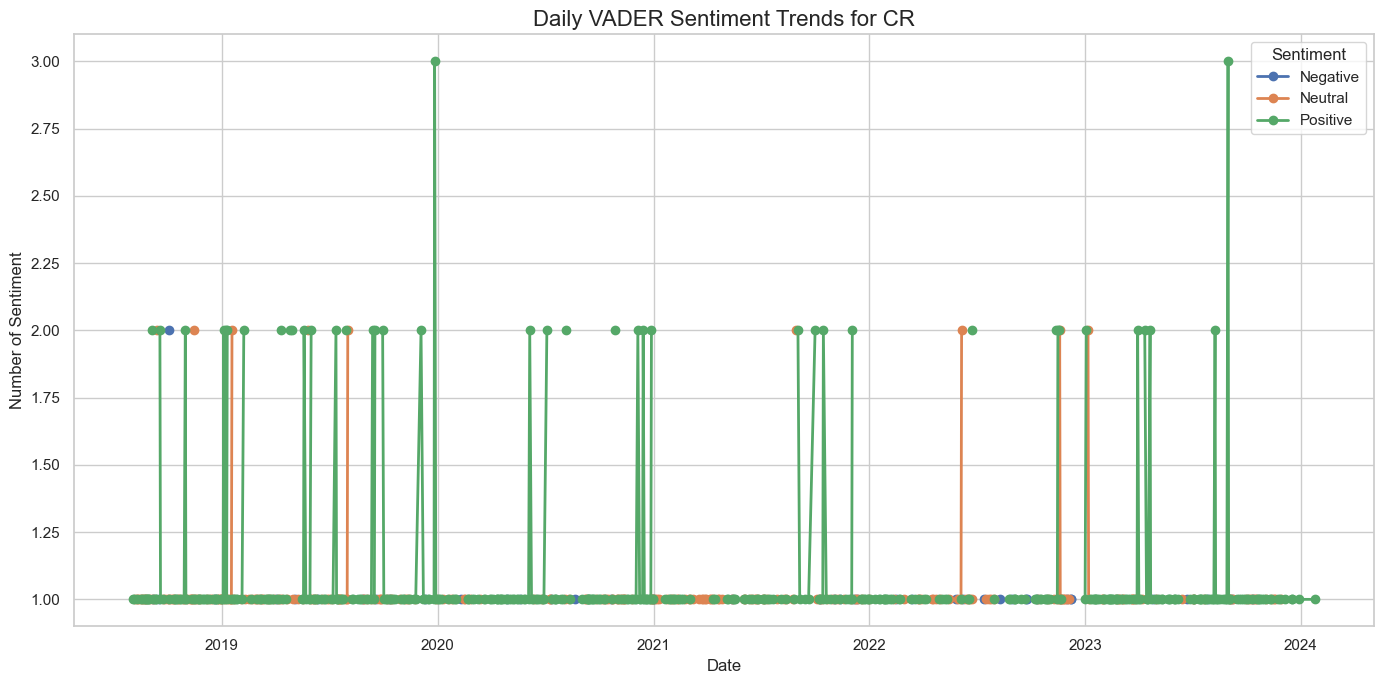

In [7]:
# Time-series sentiment trends to observe how public opinion about CR changes over time

# Group sentiment by date

cr_tweets["createdAt"] = pd.to_datetime(cr_tweets["createdAt"])                # Convert createdAt time to just date
# Group by Date and Sentiment
daily_sentiment_vd = cr_tweets.groupby(cr_tweets["createdAt"].dt.date)["sentiment_vader"].value_counts().unstack()            

# Plot time-series chart

plt.figure(figsize = (12, 6))
if "positive" in daily_sentiment_vd.columns:
    plt.plot(daily_sentiment_vd.index, daily_sentimen_vd["positive"], label = "positive", marker = "o", color = "green")
if "negative" in daily_sentiment_vd.columns:
    plt.plot(daily_sentiment_vd.index, daily_sentiment_vd["negative"], label = "negative", marker = "o", color = "red")
if "neutral" in daily_sentiment_vd.columns:
    plt.plot(daily_sentiment_vd.index, daily_sentiment_vd["neutral"], label = "neutral", marker = "o", color = "skyblue")
daily_sentiment_vd.plot(kind = "line", marker = "o", figsize = (14, 7), linewidth = 2)
plt.title("Daily VADER Sentiment Trends for CR", fontsize = 16)
plt.xlabel("Date")
plt.ylabel("Number of Sentiment")
plt.grid(True)
plt.legend(title = "Sentiment")
plt.tight_layout()
plt.show()

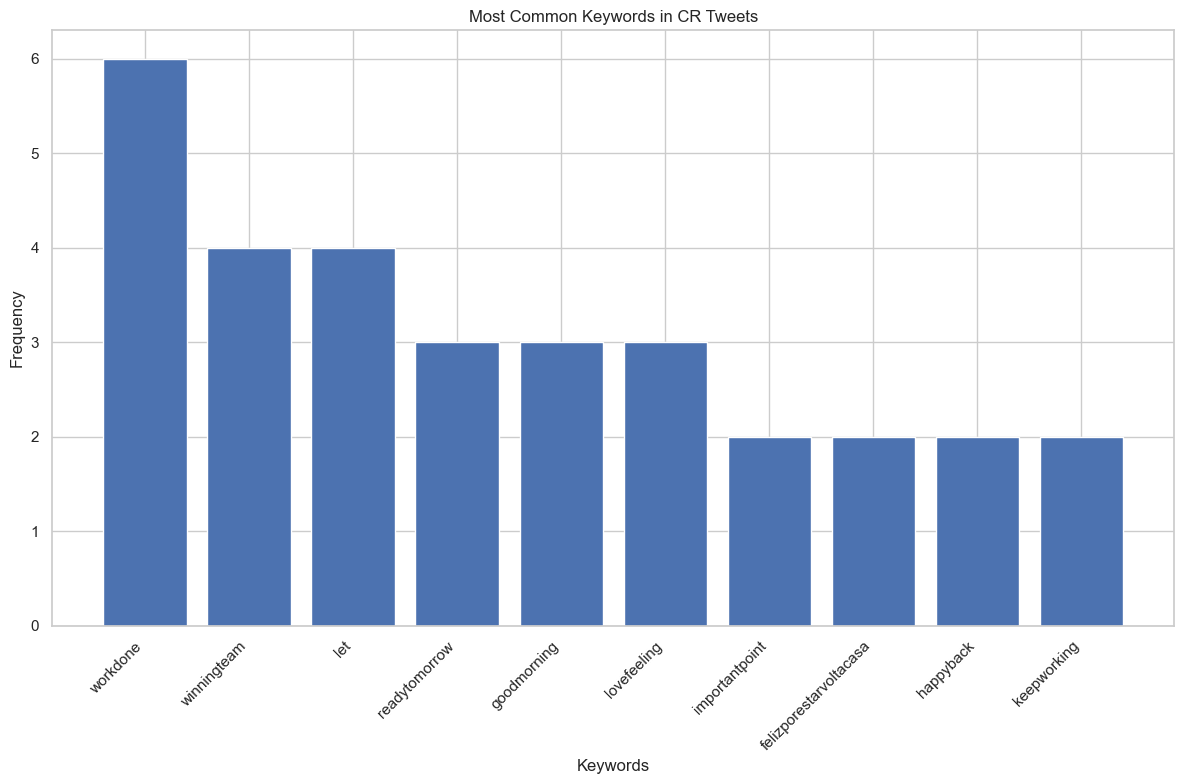

In [8]:
# Keywords Frequency chart to visualize the most common keywords

keywords, frequencies = zip(*common_keywords)
plt.figure(figsize = (12, 8))
plt.bar(keywords, frequencies)
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.title("Most Common Keywords in CR Tweets")
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()
plt.show()